In [2]:
suppressMessages(library(plyr))
suppressMessages(library(cowplot))
suppressMessages(library(data.table))
suppressMessages(library(ggplot2))
suppressMessages(library(dplyr))

jn_theme = theme(axis.text = element_text(size = 20), axis.title = element_text(size = 20), legend.text = element_text(size = 20), legend.title = element_text(size = 20)) + 
    theme(plot.margin = unit(c(1,1,1,3), "lines"),  title = element_text(size = 20), panel.background = element_blank(), axis.ticks.length=unit(0.50, "cm"), 
          axis.text = element_text(color = "black"), axis.title.x = element_text(vjust = -1), axis.title.y = element_text(vjust = 3), 
          axis.ticks = element_line(size = 1.25), panel.border = element_rect(color = "black", size = 2, fill = NA))


# Prep input

In [3]:
snp.data = fread("plink/ALL_COVID.clumped", data.table = F)
kev      = fread("boogie/Arvados-Blood-Types-and-Ethnicity/AnalyzeBloodByEthnicity/433-1000Genomes/outputBlood.csv", sep = ",")
# pop.data = fread("within.txt", data.table = F, header = F)
pop.data = fread("igsr_samples.tsv", data.table = F)
pop.data = pop.data[,c("Sample name", "Superpopulation code")]
profile  = fread("bfiles/ALL_COVID.0.000001.profile", data.table = F)
validation = fread("validation_set.txt", data.table = F)
training   = fread("training_set.txt", data.table = F)

colnames(pop.data) = c("FID", "POP")
colnames(kev)     = c("FID", "blood_group")

nrow(profile)
nrow(kev[kev$FID %in% validation$FID & kev$FID %in% profile$FID,])
nrow(kev[kev$FID %in% training$FID & kev$FID %in% profile$FID,])
head(kev[!kev$FID %in% profile$FID,])

profile$POP = suppressMessages(mapvalues(profile$FID, from = pop.data$FID, to = pop.data$POP))
profile$blood_group = suppressMessages(mapvalues(profile$FID, from = kev$FID, to = kev$blood_group))
profile = profile[profile$FID %in% kev$FID,]

profile$blood_label = ifelse(profile$blood_group != "O", "Other", "Type O")
profile$blood_label = factor(profile$blood_label, levels = c("Type O", "Other"))

nrow(profile)

[1] 1968

[1] 41

[1] 144

FID,blood_group
<chr>,<chr>
NA19097,B
NA19404,O
HG01945,O
NA19130,B
NA12376,A
HG00630,B


[1] 185

In [4]:
# Variants in ABO locus?
snp.data[snp.data$P < 0.000001 & snp.data$CHR == 9,]

,CHR,F,SNP,BP,P,TOTAL,NSIG,S05,S01,S001,S0001,SP2
,<int>,<int>,<chr>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>
14,9,1,9:117568766:A:G,117568766,3.57e-07,51,27,11,1,2,10,"9:117547772:T:C(1),9:117552885:T:C(1),9:117553249:T:C(1),9:117558703:C:T(1),9:117563687:T:G(1),9:117564875:T:C(1),9:117566440:A:G(1),9:117569046:T:C(1),9:117579457:G:A(1),9:117580914:C:T(1),9:117592778:G:T(1),9:117619214:T:C(1),9:117627569:G:T(1)"
21,9,1,9:113187399:C:A,113187399,7.79e-07,115,38,22,33,15,7,"9:113162725:A:C(1),9:113167322:A:C(1),9:113168239:A:G(1),9:113169631:G:A(1),9:113171698:T:C(1),9:113176728:T:C(1),9:113176792:C:T(1),9:113178183:G:A(1),9:113178284:T:C(1),9:113185801:A:G(1),9:113187049:G:A(1),9:113187244:A:G(1),9:113187721:A:G(1),9:113188417:T:C(1),9:113189213:T:C(1),9:113191819:T:G(1),9:113193574:C:T(1),9:113197014:C:T(1),9:113199768:C:T(1),9:113200806:T:C(1),9:113205574:A:G(1),9:113207962:A:C(1),9:113208581:C:T(1),9:113213726:A:G(1),9:113218306:T:C(1),9:113219050:G:A(1),9:113222227:A:C(1),9:113233005:C:T(1),9:113233956:C:T(1),9:113234507:T:C(1),9:113235674:G:A(1),9:113236568:T:C(1),9:113236797:T:C(1),9:113237781:T:C(1),9:113238933:C:T(1),9:113239053:C:T(1),9:113239172:T:C(1),9:113239268:C:T(1),9:113239522:C:T(1),9:113239821:G:T(1),9:113240230:T:C(1),9:113240295:A:G(1),9:113240725:C:T(1),9:113240742:C:T(1),9:113240806:C:T(1),9:113240908:C:T(1),9:113243191:C:T(1),9:113244431:A:G(1),9:113244450:G:A(1),9:113246386:A:G(1),9:113247394:G:A(1),9:113247904:C:T(1),9:113250048:A:G(1),9:113251039:A:G(1),9:113251307:C:A(1)"


# Compare O vs Other PRS

Warning message:
“`fun.y` is deprecated. Use `fun` instead.”
Warning message:
“Ignoring unknown parameters: trim”


png 
  2


	Welch Two Sample t-test

data:  nprofile[nprofile$blood_label == "Type O", "SCORE"] and nprofile[nprofile$blood_label != "Type O", "SCORE"]
t = -0.20749, df = 30.313, p-value = 0.837
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.006969968  0.005683809
sample estimates:
mean of x mean of y 
0.1008876 0.1015307 


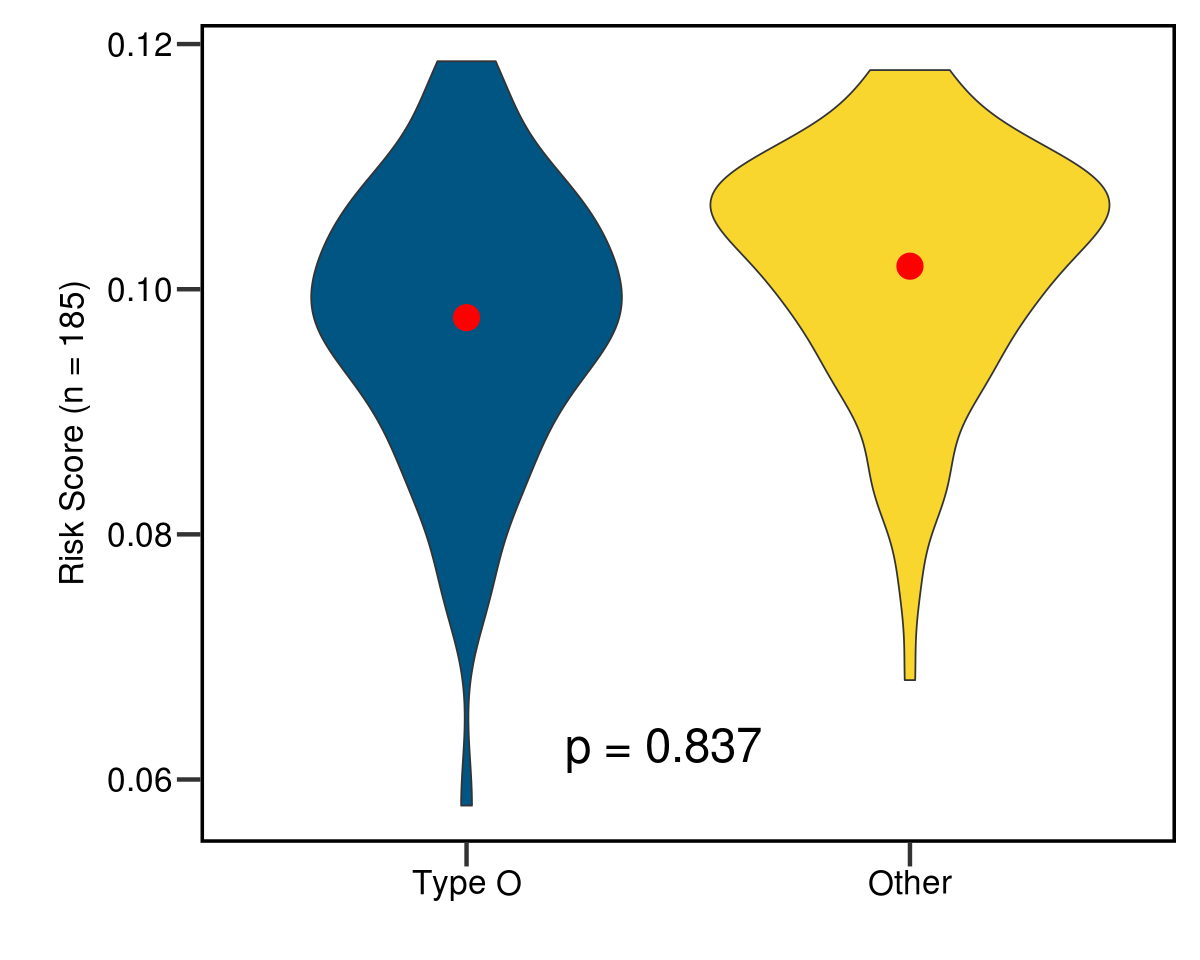

In [6]:
nprofile = profile[profile$FID %in% validation$FID, ]

png("PRS.png", width = 500, height = 500)
plt0 = ggplot(profile, aes(x = blood_label, y = SCORE, fill = blood_label)) + geom_violin() + 
    stat_summary(fun.y=mean, geom="point", size=7, color="red", trim=FALSE) +
    jn_theme + xlab("") + theme(legend.position = "none") + 
    scale_fill_manual(values = c("#005582", "#f9d62e")) +
    annotate("text", label = "p = 0.837", x = 1, y = 0.06, vjust = -0.5, hjust = -0.5,size = 10) +
    ylab("Risk Score (n = 185)")
plt0
dev.off()

options(repr.plot.width = 10, repr.plot.height = 8)
plt0
t.test(nprofile[nprofile$blood_label == "Type O", "SCORE"], nprofile[nprofile$blood_label != "Type O", "SCORE"])


# Distribution of blood group across populations

In [8]:
kev$POP = suppressMessages(mapvalues(kev$FID, from = pop.data$FID, to = pop.data$POP))

[1] "SAS" "EAS" "EUR" "AFR" "AMR"

png 
  2

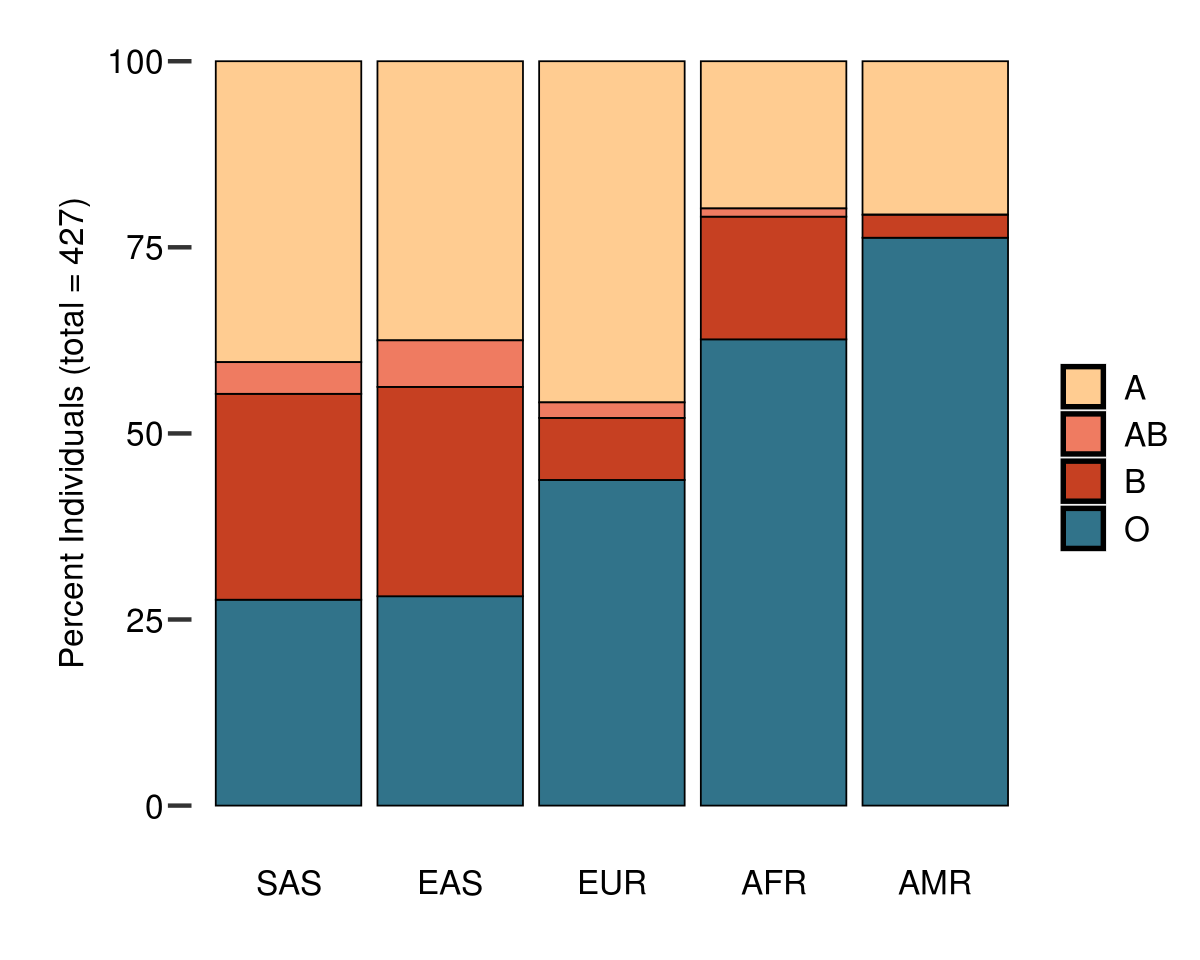

In [9]:
toplot = as.data.frame(rbindlist(lapply(unique(kev$blood_group), function(blood){
    as.data.frame(rbindlist(lapply(unique(kev$POP), function(pop){
        this = kev[kev$POP == pop,]
        total_pop = nrow(this)
        total_pop_blood = nrow(this[this$blood_group == blood,])
        
        pct = total_pop_blood / total_pop * 100
        
        data.frame(pop = pop, blood = blood, pct = pct)
        
    })))
})))

order = (toplot[toplot$blood == "O",] %>% arrange(pct))$pop
order

plt1 = ggplot(toplot, aes(x = factor(pop, levels = order), y = pct, fill = blood)) + geom_bar(stat = "identity", color = "black") + jn_theme + 
    theme(panel.border = element_blank(), axis.ticks.x = element_blank()) + xlab("") + ylab("Percent Individuals (total = 427)") + 
    scale_fill_manual(values = c("#ffcc91", "#ef7b61", "#c64022", "#31738a"), name = "") +
    guides(fill = guide_legend(override.aes = list(size = 10)))

png("pop_blood.png", width = 500, height = 500)
plt1
dev.off()

options(repr.plot.width = 10, repr.plot.height = 8)
plt1

# Association between blood, population, and PRS

png 
  2

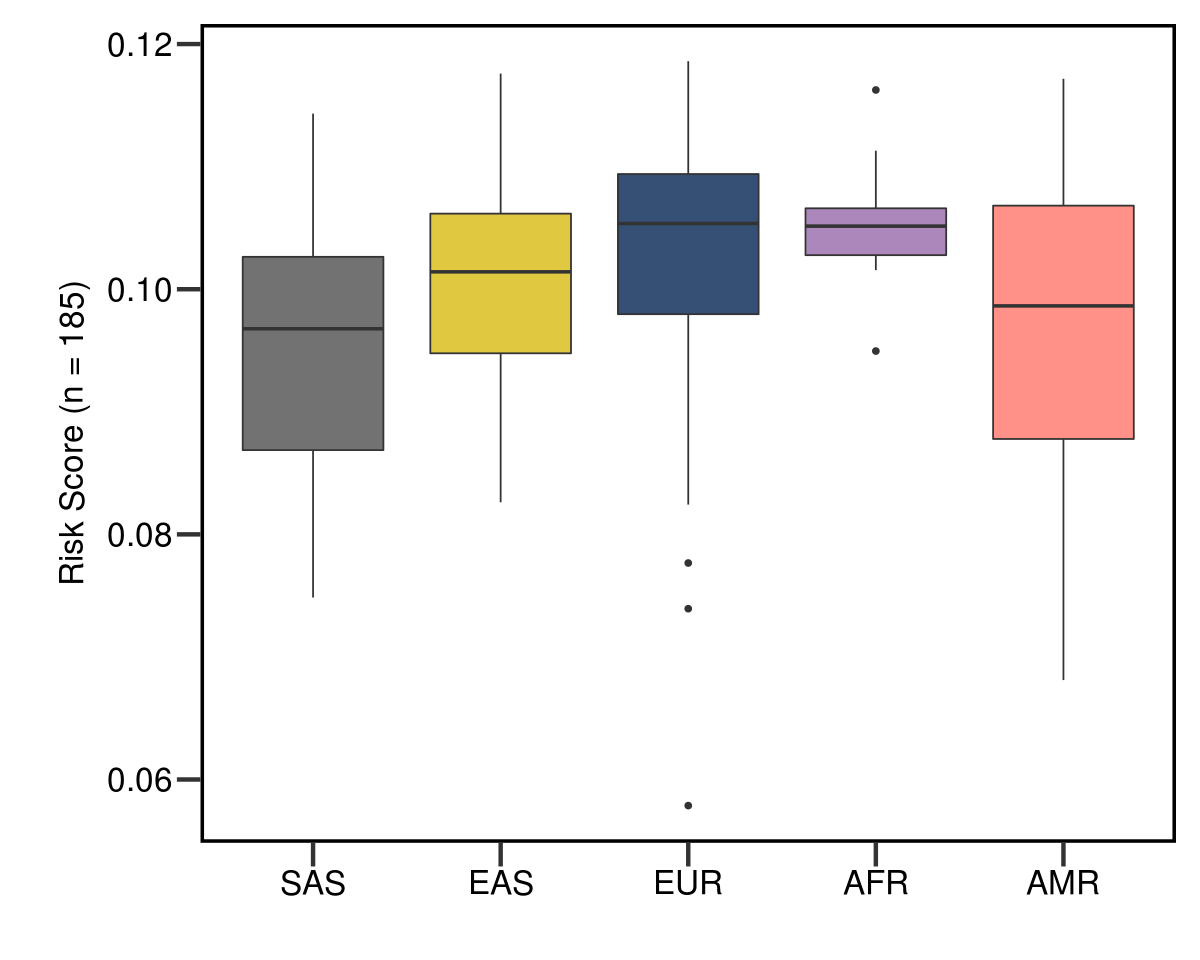

In [15]:
plt2 = ggplot(profile, aes(x = factor(POP, levels = order), y = SCORE, fill = POP)) + geom_boxplot() + jn_theme + 
    scale_fill_manual(values = c("#ac87bb", "#ff9188", "#e0c841", "#354f75", "#727272"), name = "") + xlab("") +
    guides(fill = guide_legend(override.aes = list(size = 1))) + 
    theme(legend.position = "none") + ylab("Risk Score (n = 185)") +
#     geom_segment(aes(x = 1, y = 0.12, xend = 2, yend = 0.12)) +
#     geom_text(x = 1.5, y = 0.1205, label = "*", size = 10) +
#     ylim(0.06, 0.13) + 
#     geom_segment(aes(x = 1, y = 0.125, xend = 3, yend = 0.125)) +
#     geom_text(x = 2, y = 0.125, label = "**", size = 10) +
#     geom_segment(aes(x = 1, y = 0.128, xend = 4, yend = 0.128)) +
#     geom_text(x = 2.5, y = 0.128, label = "**", size = 10) +
#     geom_segment(aes(x = 2.1, y = 0.12, xend = 4, yend = 0.12)) +
#     geom_text(x = 3.0, y = 0.12, label = "*", size = 10) +

#     geom_segment(aes(x = 4.1, y = 0.12, xend = 5, yend = 0.12)) +
#     geom_text(x = 4.5, y = 0.12, label = "*", size = 10)

png("pop_score.png", width = 600, height = 500)
plt2
dev.off()

options(repr.plot.width = 10, repr.plot.height = 8)
plt2

In [16]:
t.test(profile[profile$POP == "EUR", "SCORE"], profile[profile$POP == "AFR", "SCORE"])


	Welch Two Sample t-test

data:  profile[profile$POP == "EUR", "SCORE"] and profile[profile$POP == "AFR", "SCORE"]
t = -1.0777, df = 18.565, p-value = 0.295
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.007877511  0.002528243
sample estimates:
mean of x mean of y 
0.1028334 0.1055080 


# plot all

png 
  2

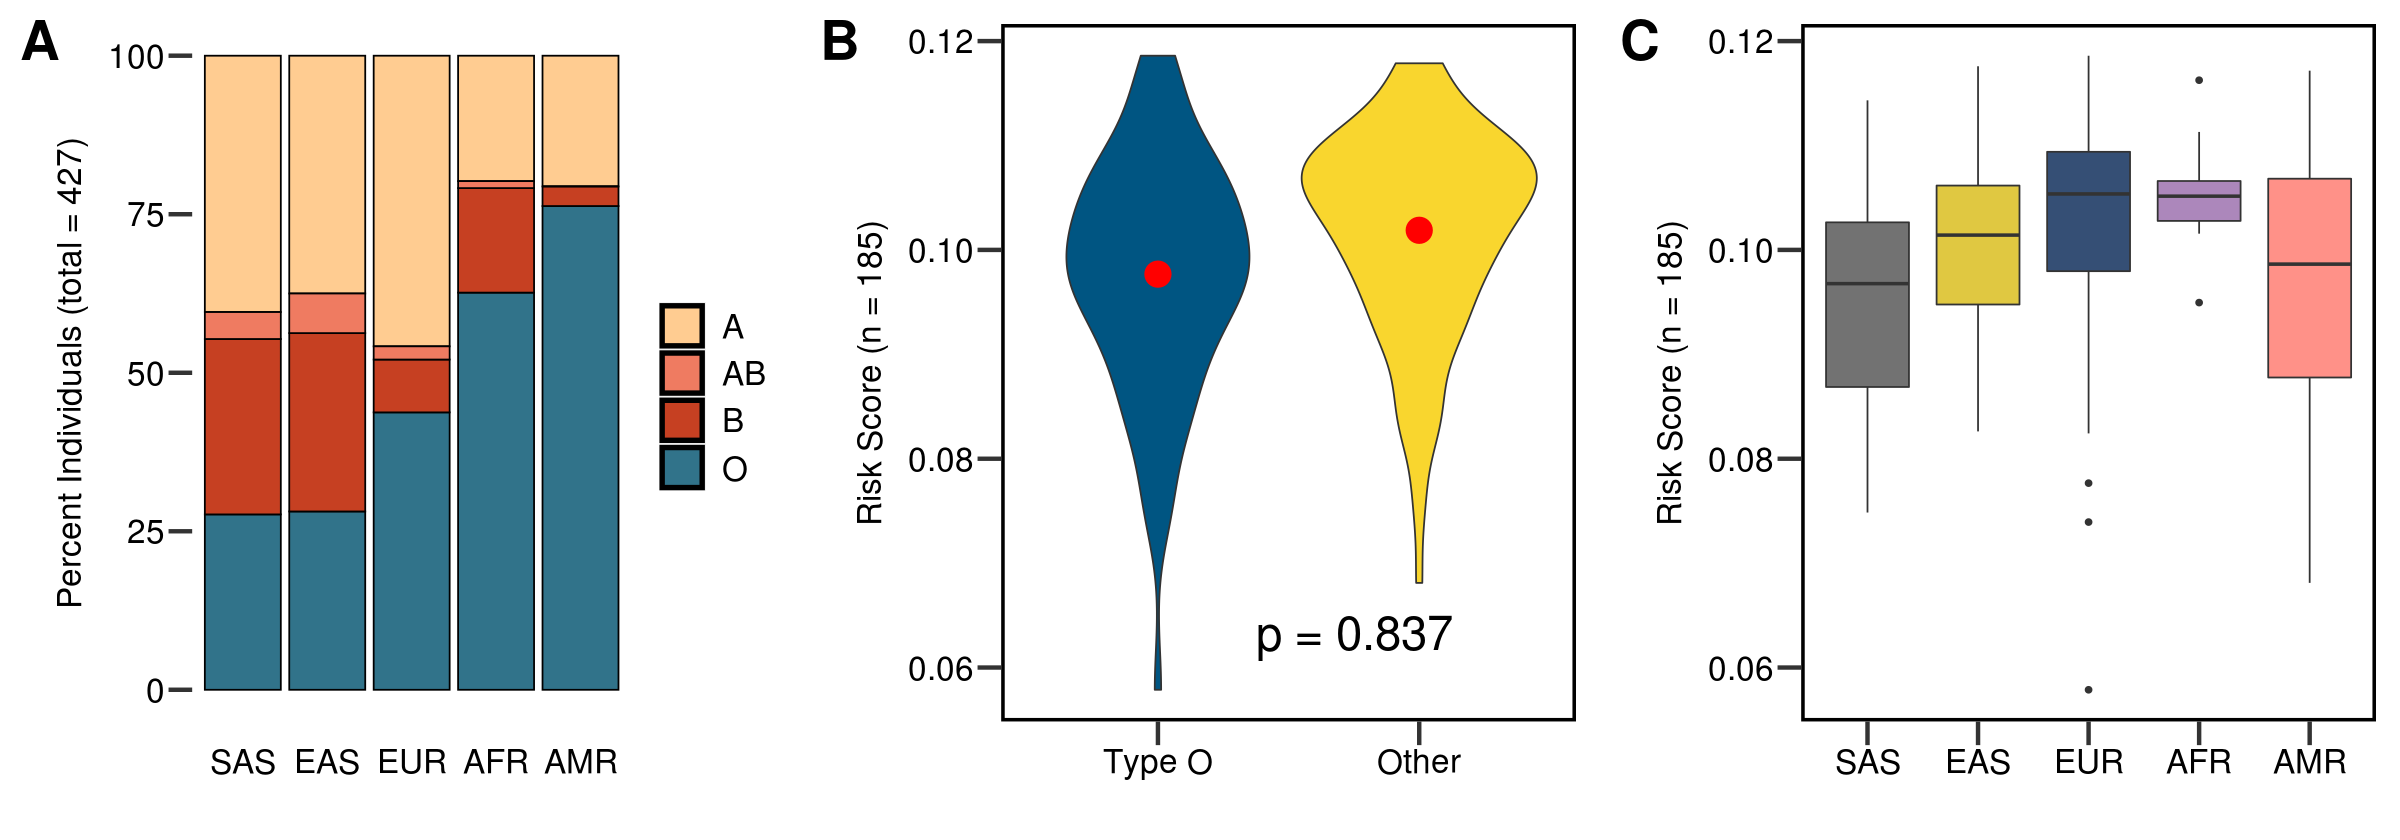

In [17]:
grid = plot_grid(plotlist = list(plt1, plt0, plt2), labels = "AUTO", label_size = 33, nrow = 1)

png("pop_score_blood.png", width = 1500, height = 500)
grid
dev.off()

options(repr.plot.height = 7, repr.plot.width = 20)
grid